In [1]:
import os
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import re
import seaborn as sns 
from scipy.stats import norm
from bertopic import BERTopic
import nltk
from transformers import BertTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import webbrowser

c:\huy\newPython\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\huy\newPython\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\huy\newPython\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supp

In [2]:
# Define the directory where the files are located
directory = os.path.normpath("data")

# Define the output file path
output_file = 'output.txt'

# Get the list of files in the directory
file_list = os.listdir(directory)

# Sort the file list to ensure consistent order
file_list.sort()

# Initialize a flag to track if the first file has been processed
first_file_processed = False

# Iterate over the files
with open(output_file, 'w', encoding="utf-8") as outfile:
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        with open(file_path, 'r', encoding="utf-8") as infile:
            # Skip the first row if it's not the first file
            if first_file_processed:
                next(infile)
            else:
                first_file_processed = True
            # Append the remaining rows to the output file
            for line in infile:
                outfile.write(line)

In [3]:
df = pd.read_csv('output.txt', delimiter='\t')

In [4]:
# Specify the column names wanted to select
selected_columns = ['AU', 'TI', 'SO', 'PY','AB']  
df_selected = df[selected_columns]
display(df_selected.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   AU      4999 non-null   object
 1   TI      5000 non-null   object
 2   SO      5000 non-null   object
 3   PY      5000 non-null   int64 
 4   AB      4994 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


None

In [5]:
display(df_selected.head(5))

,AU,TI,SO,PY,AB
0,Yu-Xiao Wang; Yue Xin; Jun-Yi Yin; Xiao-Jun Hu...,Revealing the architecture and solution proper...,Food Chemistry,2022,Macrolepiota albuminosa (Berk.) Pegler is abun...
1,Yu-Xiao Wang; Yue Xin; Xiao-Jun Huang; Jun-Yi ...,A branched galactoglucan with flexible chains ...,Food Chemistry,2022,A homogeneous galactoglucan was purified from ...
2,Yu-Xiao Wang; Ting Zhang; Jun-Yi Yin; Xiao-Jun...,Structural characterization and rheological pr...,Food Hydrocolloids,2022,A homogeneous beta-glucan (JHMP-70) was obtain...
3,Yu-Xin Gu; Tian-Ci Yan; Zi-Xuan Yue; Min-Hui L...,Dispersive micro-solid-phase extraction of aca...,Food Analytical Methods,2022,A novel dispersive micro-solid-phase extractio...
4,Yu-Xue Xu; Ze-Dong Jiang; Xi-Ping Du; Ming-Jin...,The identification of biotransformation pathwa...,Food Chemistry,2022,The yeast Saccharomyces cerevisiae is effectiv...


# DATA PREPROCESSING 
        1. Remove any rows that has at least blank value
        2. Remove "Publisher copyright" in the last sentence of the abstract
        3. Remove stopwords and do lemmatisation
        4. Remove outliers


## 1. Remove any rows that has 1 or more than 1 blank value

In [6]:
df = df_selected.isnull()
# Check for blank or missing values in the DataFrame
blank_values = df.sum()

# Print the count of blank values for each column
print("Number of Blanks")
print(blank_values)
print("Total of Blanks =",sum(blank_values))

Number of Blanks
AU    1
TI    0
SO    0
PY    0
AB    6
dtype: int64
Total of Blanks = 7


In [7]:
df_selected.dropna(inplace=True)
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   AU      4993 non-null   object
 1   TI      4993 non-null   object
 2   SO      4993 non-null   object
 3   PY      4993 non-null   int64 
 4   AB      4993 non-null   object
dtypes: int64(1), object(4)
memory usage: 234.0+ KB


## 2. Remove "Publisher copyright" in the last sentence of the abstract

In [8]:
abstract_list = df_selected["AB"].to_list()

# Split an abstract into different sublist of sentences
abstract = [i.split(".") for i in abstract_list]  

# Remove sublist that contains only space
sentences_of_abstract = [[value for value in row if value.strip()] for row in abstract] 

In [9]:
def remove_pattern(pattern, list_AB):
    '''
    The function is to search for a patter
    and remove the sentence has that pattern
    -----------------------------
    Parameter:

    pattern: the pattern that wanted to be found
    list_AB: the list of abstracts/sentences
    -----------------------------
    Return

    list_AB: An update of list_AB where the sentences
    have the pattern already removed
    '''
    for sentences in list_AB:
        for sub_sent in sentences:
            if re.search(pattern, sub_sent):
                sentences.remove(sub_sent)
    return list_AB


In [10]:
# List of copyright patterns
remove_pattern_list = ["Corrected publication 2021",
                       "Wiley",
                       "Licensee MDPI, Basel, Switzerland",
                       "Published by Cambridge University Press on behalf of Hannah Dairy Research Foundation",
                       "Published with license by Taylor & Francis Group, LLC",
                       "[See EFSA Journal19 (10) e06852 for part 1]",
                       "Springer Nature",
                       "\[This paper was presented at",
                       "gov with the identifier NCT03622762",
                       "gov (NCT03577834)",
                       "©",
                       "All rights reserved"]

# Remove the copyright patterns out of the abstracts
for pattern in remove_pattern_list:
    regex = re.compile(re.escape(pattern))
    sentences_of_abstract = remove_pattern(regex,sentences_of_abstract)


In [11]:
# Replace the AB column by the sentences_of_abstract where unwanted sentences were removed
df_selected["AB"] = sentences_of_abstract
display(len(df_selected))

4993

In [12]:
# Remove the records where AB feature is empty
df_selected = df_selected[df_selected['AB'].apply(lambda x: len(x) > 0)]
display(len(df_selected))

4992

In [13]:
# Combine sublists of each abstract to 1 list 
for i in range(len(df_selected)):
    df_selected["AB"].iloc[i] = ''.join(df_selected["AB"].iloc[i])

df_selected["AB"]

0       Macrolepiota albuminosa (Berk) Pegler is abund...
1       A homogeneous galactoglucan was purified from ...
2       A homogeneous beta-glucan (JHMP-70) was obtain...
3       A novel dispersive micro-solid-phase extractio...
4       The yeast Saccharomyces cerevisiae is effectiv...
                              ...                        
4995    The high moisture and nutrient contents of spi...
4996    Inhibition of Salmonella by Lactobacillus has ...
4997    Lipid accumulation is a major factor in the de...
4998    Soybean milk is an economical substitute for d...
4999    This paper reports on an experimental investig...
Name: AB, Length: 4992, dtype: object

## 3. Remove stopwords and do lemmatisation

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Create a custom stopword list
custom_stopwords = list(stopwords.words('english')) + list(ENGLISH_STOP_WORDS)
lemmatizer = WordNetLemmatizer()

docs = df_selected["AB"].to_list()
preprocessed_docs = []

for sentence in docs:
    # Split the sentence into words
    words = sentence.split()
    # Remove stopwords and perform lemmatization
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in custom_stopwords]
    # Join the filtered words back into a sentence
    processed_sentence = ' '.join(filtered_words)
    # Add the processed sentence to the list
    preprocessed_docs.append(processed_sentence)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huyca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\huyca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Replace the df_select["AB"] with the prprocessed_docs
df_selected["AB"] = preprocessed_docs

In [16]:
df_selected["AB"]

0       macrolepiota albuminosa (berk) pegler abundant...
1       homogeneous galactoglucan purified alkali-extr...
2       homogeneous beta-glucan (jhmp-70) obtained hyp...
3       novel dispersive micro-solid-phase extraction ...
4       yeast saccharomyces cerevisiae effective reduc...
                              ...                        
4995    high moisture nutrient content spiced beef mak...
4996    inhibition salmonella lactobacillus popular re...
4997    lipid accumulation major factor development no...
4998    soybean milk economical substitute dairy produ...
4999    paper report experimental investigation drying...
Name: AB, Length: 4992, dtype: object

## 4. Remove outliers

In [17]:
# Count number of words in each abstract
abstract_len_list = [len(sentence.split()) for sentence in df_selected["AB"].tolist()] 

# Create a new column named Length of Abstract
df_selected["Length of Abstract"] = abstract_len_list 
df_selected.head(5)

,AU,TI,SO,PY,AB,Length of Abstract
0,Yu-Xiao Wang; Yue Xin; Jun-Yi Yin; Xiao-Jun Hu...,Revealing the architecture and solution proper...,Food Chemistry,2022,macrolepiota albuminosa (berk) pegler abundant...,85
1,Yu-Xiao Wang; Yue Xin; Xiao-Jun Huang; Jun-Yi ...,A branched galactoglucan with flexible chains ...,Food Chemistry,2022,homogeneous galactoglucan purified alkali-extr...,103
2,Yu-Xiao Wang; Ting Zhang; Jun-Yi Yin; Xiao-Jun...,Structural characterization and rheological pr...,Food Hydrocolloids,2022,homogeneous beta-glucan (jhmp-70) obtained hyp...,124
3,Yu-Xin Gu; Tian-Ci Yan; Zi-Xuan Yue; Min-Hui L...,Dispersive micro-solid-phase extraction of aca...,Food Analytical Methods,2022,novel dispersive micro-solid-phase extraction ...,115
4,Yu-Xue Xu; Ze-Dong Jiang; Xi-Ping Du; Ming-Jin...,The identification of biotransformation pathwa...,Food Chemistry,2022,yeast saccharomyces cerevisiae effective reduc...,91


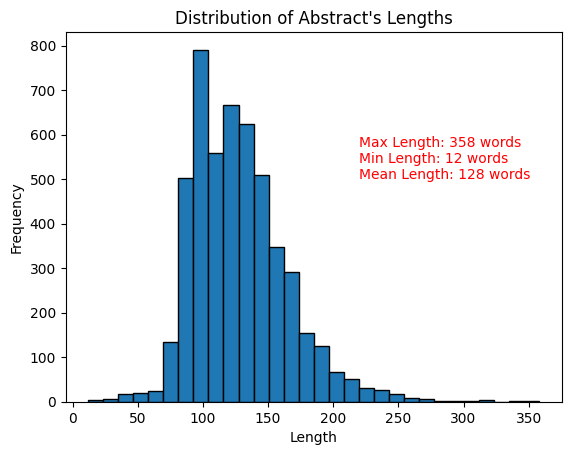

In [18]:
# Visualise length of abstract
max_length  = max(abstract_len_list)
min_length = min(abstract_len_list)
mean_length = sum(abstract_len_list)/len(abstract_len_list)
text = f'Max Length: {max_length} words \nMin Length: {min_length} words \nMean Length: {round(mean_length)} words'
plt.hist(abstract_len_list, bins=30, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.text(220, 500, text, size = 10, color = "red")
plt.title('''Distribution of Abstract's Lengths''')
# Save the plot as a PNG file
#plt.savefig('abstract_len_1.png')
plt.show()

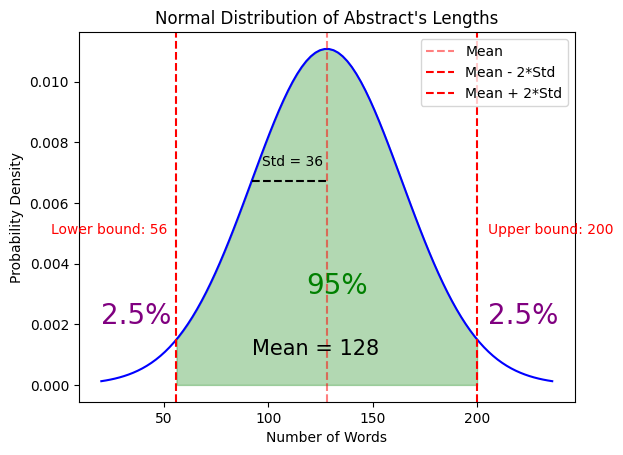

In [19]:
# Generate random data
data = np.array(abstract_len_list)

# Calculate mean and standard deviation
mean = round(np.mean(data))
std = round(np.std(data))

# Create x-axis values
x = np.linspace(mean - 3 * std, mean + 3 * std, 100)

# Create normal distribution curve
y = stats.norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, y, color='blue')

# Calculate the upper and lower bound
lower_bound = round(mean - 2 * std)
upper_bound = round(mean + 2 * std)

# List of outliers
outliers_list = [x for x in abstract_len_list if x < lower_bound or x > upper_bound]

inlier_percentage = (len(abstract_len_list) - len(outliers_list))/len(abstract_len_list)*100
inlier_number = len(abstract_len_list) - len(outliers_list)
outlier_percentage = len(outliers_list)/len(abstract_len_list)*100
outlier_number = len(outliers_list)

# Add standard deviation vertical lines
plt.axvline(mean, color='red', linestyle='dashed', label='Mean', alpha = 0.5)
plt.axvline(mean - 2*std, color='red', linestyle='dashed', label='Mean - 2*Std')
plt.axvline(mean + 2*std, color='red', linestyle='dashed', label='Mean + 2*Std')

# Draw standard deviation horizontal line
x_point = mean + std
y_point = norm.pdf(x_point, mean, std)
plt.hlines(y=y_point,xmax=round(mean), xmin=round(mean-std), color='black', linestyle='--')

# Text the standard deviation and Mean
plt.text(round(mean-std)+5,y_point + 0.0005,f'Std = {std}', size=10, color="black")
plt.text(mean-std,0.001,f'Mean = {mean}', size=15, color="black")

# Text for upper and lower bound
plt.text(mean+2*std+5,0.005,f"Upper bound: {upper_bound}", color = "r")
plt.text(mean-4*std+12,0.005,f"Lower bound: {lower_bound}", color = "r")

# Text the Inlier percentage
plt.text(mean-10,0.003,f"{round(inlier_percentage)}%", color = "green", size=20)
# Text the Lower bound percentage
plt.text(mean-3*std,0.002,f"{round(outlier_percentage)/2}%", color = "purple", size=20)
# Text the Upper bound percentage
plt.text(mean+2*std+5,0.002,f"{round(outlier_percentage)/2}%", color = "purple", size=20)


# Color the inlier area
x_shade = np.linspace(mean - 2 * std, mean + 2 * std, 100)
y_shade = stats.norm.pdf(x_shade, mean, std)
plt.fill_between(x_shade, y_shade, color='green', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('''Number of Words''')
plt.ylabel('Probability Density')
plt.title('''Normal Distribution of Abstract's Lengths''')

# Save the plot as a PNG file
plt.savefig('normal_distribution.png')

# Show the plot
plt.show()


In [20]:
# Remove the records that have abstract length in the outliers_list
df_selected = df_selected[~df_selected['Length of Abstract'].isin(outliers_list)]
len(df_selected)

4760

# VISUALISATION
        1. Published Year (PY)
        2. Journals (SO)
        3. Length of Abstract

## 1. Published Year (PY)

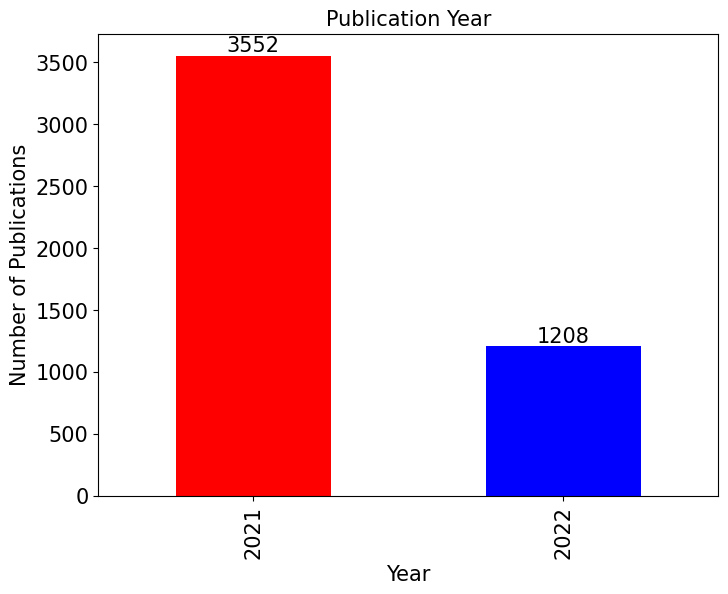

In [21]:
# Get value and count of each journal
y_PY = df_selected["PY"].value_counts()

# Set the figure size
plt.figure(figsize=(8, 6))

# Add labels and title
plt.xlabel("Year", size=15)
plt.ylabel("Number of Publications", size=15)
plt.title("Publication Year", size=15)

# Plot histogram with specified colors
ax = y_PY.plot.bar(color=["red", "blue"])

# Add labels inside the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', size = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("published_year.png")

plt.show()


## 2. Journal (SO)

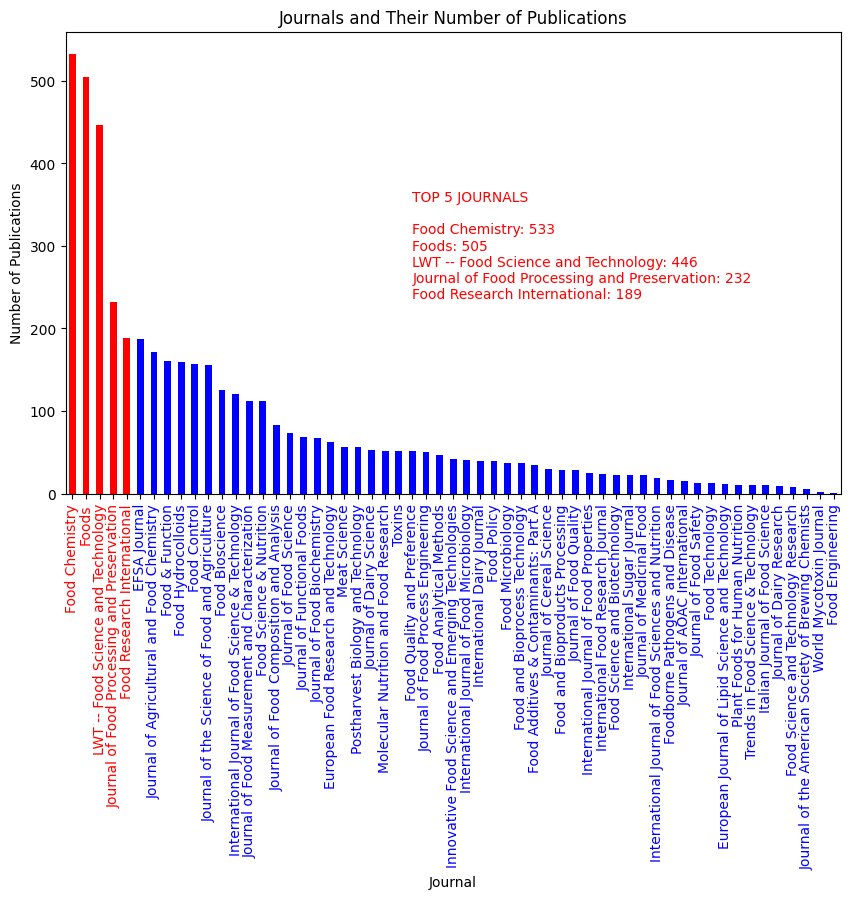

In [22]:
# Assuming you have a DataFrame named 'df_selected' and 'y_SO' is the value counts of 'SO' column
y_SO = df_selected["SO"].value_counts()

# Set the figure size
plt.figure(figsize=(10, 6))

# Get the top 5 journals
top_5 = y_SO.head(5).to_dict()

# Create the text to display
text = '\n'.join([f'{k}: {v}' for k, v in top_5.items()])
text = "TOP 5 JOURNALS\n\n" + text

# Add labels and title
plt.xlabel("Journal")
plt.ylabel("Number of Publications")
plt.text(25, 300, text, ha="left", va="center", color="red")

plt.title("Journals and Their Number of Publications")

# Set the color for the top 10 journals (red)
colors = ['red' if journal in top_5 else 'blue' for journal in y_SO.index]

# Plot histogram with specified colors
y_SO.plot.bar(color=colors)

# Get the tick labels
tick_labels = plt.gca().get_xticklabels()

# Iterate over tick labels and assign a color
for i, tick_label in enumerate(tick_labels):
    if tick_label.get_text() in top_5:
        tick_label.set_color('red')
    else:
        tick_label.set_color('blue')
# Save image as a png file
plt.savefig("journal.png")
# Show the plot
plt.show()


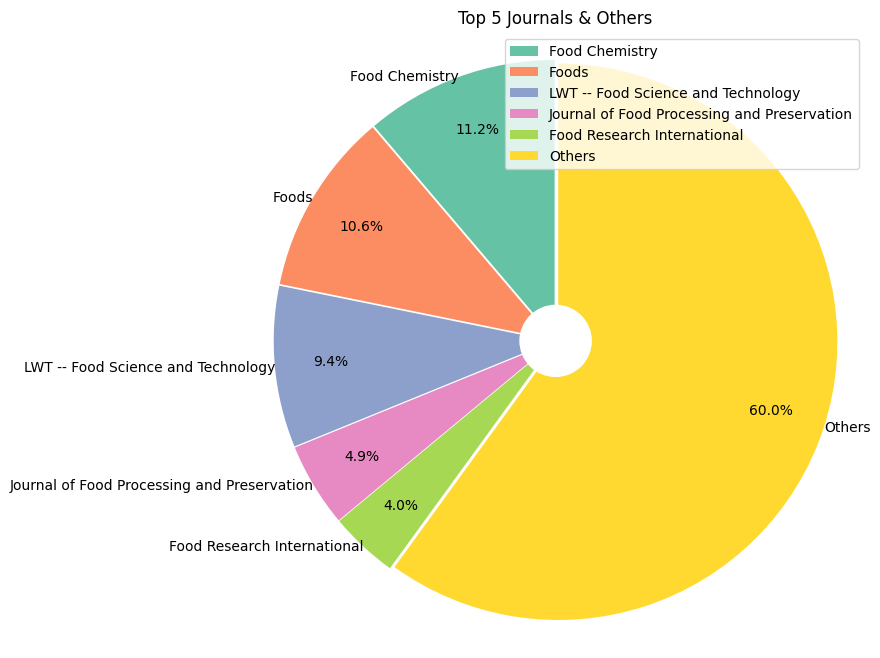

In [23]:
import matplotlib.pyplot as plt

# Get the top ten journals and their publication counts
top_journals = df_selected['SO'].value_counts().head(5)
other_count = df_selected['SO'].value_counts().sum() - top_journals.sum()

# Create a new DataFrame for the top ten journals and "Others"
data = pd.concat([top_journals, pd.Series(other_count, index=['Others'])])

# Define colors for each slice
colors = sns.color_palette('Set2')

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, radius=5, labels=data.index, labeldistance=1, colors=colors, autopct='%1.1f%%', startangle=90,
        pctdistance=0.80, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Top 5 Journals & Others')
plt.axis('equal')
plt.legend()
# Save the plot as a PNG file
plt.savefig('pie_chart.png')
plt.show()


## 3. Length of Abstract

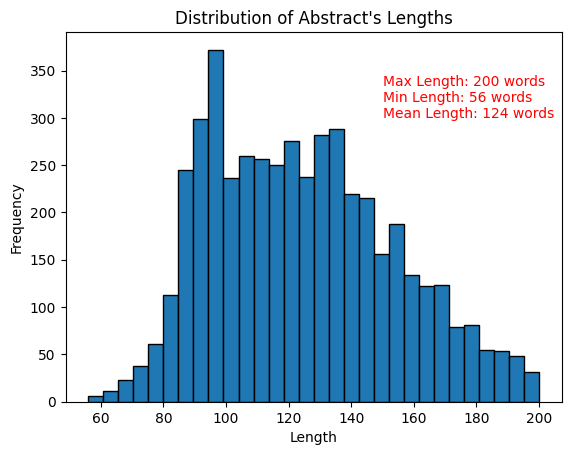

In [24]:
# Visualise length of abstract
abstract_len_list = df_selected["Length of Abstract"].to_list()
max_length  = max(abstract_len_list)
min_length = min(abstract_len_list)
mean_length = sum(abstract_len_list)/len(abstract_len_list)
text = f'Max Length: {max_length} words \nMin Length: {min_length} words \nMean Length: {round(mean_length)} words'
plt.hist(abstract_len_list, bins=30, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.text(150, 300, text, size = 10, color = "red")
plt.title('''Distribution of Abstract's Lengths''')
# Save image as a png file
plt.savefig("abstract_len_2.png")
plt.show()

In [25]:
len(df_selected)

4760

In [26]:
df_selected.to_csv("result_for_visualisation.csv")

# TOPIC MODELLING USING BERTtopic
        
        

## 1. Data Splitting

In [27]:
joural_list = df_selected["SO"].to_list()
abstract_list = df_selected["AB"].to_list()

## 1. Baseline Model

In [28]:
# Initialise BERTopic model
from umap import UMAP
from bertopic import BERTopic
from hdbscan import HDBSCAN

umap_model = UMAP(random_state=42)

baseline_model = BERTopic(language="english", calculate_probabilities=True, 
                        verbose=True, top_n_words=10, n_gram_range =(1,1), 
                        umap_model=umap_model)

baseline_model_topic, baseline_model_prob = baseline_model.fit_transform(abstract_list)

Batches:   0%|          | 0/149 [00:00<?, ?it/s]

2023-07-09 19:51:44,297 - BERTopic - Transformed documents to Embeddings
2023-07-09 19:52:25,639 - BERTopic - Reduced dimensionality
2023-07-09 19:52:27,774 - BERTopic - Clustered reduced embeddings


In [29]:
baseline_model_topic_dict = dict(baseline_model.topic_sizes_)
number_topics = len(baseline_model_topic_dict)
print("Number of Topics:", number_topics)

Number of Topics: 78


In [30]:
baseline_model_topic_dict

{60: 15,
 -1: 1645,
 4: 120,
 24: 41,
 16: 52,
 41: 24,
 0: 204,
 22: 45,
 28: 37,
 21: 45,
 9: 75,
 55: 17,
 47: 19,
 13: 59,
 8: 81,
 14: 59,
 7: 95,
 40: 24,
 32: 35,
 61: 15,
 1: 160,
 64: 14,
 26: 39,
 15: 55,
 17: 51,
 5: 96,
 75: 11,
 2: 158,
 63: 14,
 10: 72,
 19: 47,
 11: 65,
 43: 22,
 37: 29,
 3: 146,
 74: 11,
 25: 40,
 36: 30,
 29: 36,
 62: 15,
 68: 12,
 33: 33,
 46: 20,
 23: 42,
 42: 23,
 39: 26,
 12: 60,
 44: 21,
 18: 49,
 31: 35,
 38: 26,
 45: 20,
 57: 16,
 35: 33,
 50: 19,
 67: 12,
 51: 19,
 76: 10,
 27: 38,
 66: 12,
 70: 11,
 58: 15,
 20: 45,
 71: 11,
 72: 11,
 59: 15,
 73: 11,
 53: 18,
 56: 16,
 65: 13,
 48: 19,
 49: 19,
 54: 17,
 6: 96,
 69: 12,
 52: 18,
 34: 33,
 30: 36}

In [32]:
# Convert the dictionary to a DataFrame
baseline_model_topic_df = pd.DataFrame.from_dict(baseline_model_topic_dict, orient='index', columns=['Count'])

# Reset the index to create a column for the 'Topic' values
baseline_model_topic_df.reset_index(inplace=True)
baseline_model_topic_df.rename(columns={'index': 'Topic'}, inplace=True)

# Sort the DataFrame based on the 'Topic' column
baseline_model_topic_df.sort_values(by='Topic', inplace=True)

baseline_model_topic_df.to_csv("baseline_model_topic_df.csv")
# Display the resulting DataFrame
print(baseline_model_topic_df)

    Topic  Count
1      -1   1645
6       0    204
20      1    160
27      2    158
34      3    146
..    ...    ...
64     72     11
66     73     11
35     74     11
26     75     11
57     76     10

[78 rows x 2 columns]


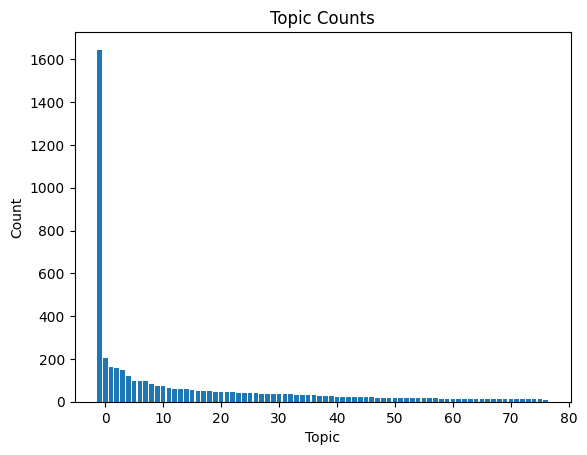

In [33]:
# Extract the topics and counts from the dictionary
topics = list(baseline_model_topic_dict.keys())
counts = list(baseline_model_topic_dict.values())

# Create the bar chart
plt.bar(topics, counts)

# Add labels and title
plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("Topic Counts")

# Show the plot
plt.show()

In [34]:
# Table of topics
topic_table = baseline_model.get_topic_info()
topic_table.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1645,-1_study_acid_effect_activity,"[study, acid, effect, activity, food, showed, ...","[effect cold plasma enzymatic activity, color,..."
1,0,204,0_food_consumer_consumers_perception,"[food, consumer, consumers, perception, meat, ...",[dairy industry generates large volume liquid ...
2,1,160,1_fermentation_fermented_acid_probiotic,"[fermentation, fermented, acid, probiotic, pla...",[fermentation various food stuff lactic acid b...
3,2,158,2_flour_bread_wheat_dough,"[flour, bread, wheat, dough, gluten, pasta, gl...",[wheat bran incorporation bread multiple healt...
4,3,146,3_meat_muscle_beef_fatty,"[meat, muscle, beef, fatty, fat, lipid, acid, ...",[studied effect high linolenic acid diet suppl...


In [35]:
# Visualise topics using hierarchical clustering
hierarchical_fig = baseline_model.visualize_hierarchy(top_n_topics=number_topics)
hierarchical_fig

In [36]:
# Generate the figure using baseline_model.visualize_topics()
fig_cluster = baseline_model.visualize_topics()[0]

# Save the figure as HTML
html_filename = "cluster_visualization.html"
fig_cluster.write_html(html_filename)

In [37]:
fig_cluster

In [38]:
# Print the first 10 topics and their represetation words
fig_topic_words = baseline_model.visualize_barchart(top_n_topics=number_topics-1)
fig_topic_words

In [39]:
# Save the figure as HTML
html_filename = "topic_words_fig.html"
fig_topic_words.write_html(html_filename)

In [40]:
def Evaluataion(model, val_data):
    '''
    Evaluate the model using topic coherence (c_v)
    -----------------------
    Parameter

    model: the already trained model
    val_data: validation data
    -----------------------
    Return
    
    coherence: coherence score
    '''
    
    import gensim.corpora as corpora
    from gensim.models.coherencemodel import CoherenceModel

    # Extract vectorizer and tokenizer from BERTopic
    vectorizer = model.vectorizer_model
    tokenizer = vectorizer.build_tokenizer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [tokenizer(doc) for doc in val_data]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in model.get_topic(topic)] 
               for topic in range(len(set(model.get_topic_freq()))-1)]


    # Evaluate
    c_v_model = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_v')
    
    c_npmi_model = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_npmi')
    
    c_v_score = c_v_model.get_coherence()
    c_npmi_score = c_npmi_model.get_coherence()
    return c_v_score, c_npmi_score


In [41]:
# Print coherence score
cv_score, c_npmi_score = Evaluataion(baseline_model, abstract_list)
print("c_v score:", cv_score)
print("c_npmi score:", c_npmi_score)

c_v score: 0.6676749452257555
c_npmi score: 0.11352133598672967


In [42]:
similar_topics, similarity = baseline_model.find_topics("microbiota", top_n=3)
similar_topics, similarity
# microbiology, protein, vitamin, pesticide

([28, 22, 44], [0.47920734, 0.44600815, 0.43153465])

In [43]:
baseline_model.get_topic(28)

[('biofilm', 0.060841603540201204),
 ('biofilms', 0.033856716490705),
 ('gene', 0.030117135502713558),
 ('strain', 0.02851362876791986),
 ('monocytogenes', 0.01958920526997085),
 ('formation', 0.018745970102256797),
 ('isolates', 0.016850100644663912),
 ('resistance', 0.015465104351452912),
 ('spoilage', 0.015041012787415936),
 ('freshness', 0.014940503249926067)]

## New Model


In [44]:
from bertopic import BERTopic

#umap_model = UMAP(random_state=30)

new_model = BERTopic(language="english", calculate_probabilities=True, 
                        verbose=True, top_n_words=10, n_gram_range =(1,1),
                        min_topic_size=30)

topics, probs = new_model.fit_transform(abstract_list)

Batches:   0%|          | 0/149 [00:00<?, ?it/s]

2023-07-09 20:09:36,696 - BERTopic - Transformed documents to Embeddings
2023-07-09 20:09:50,742 - BERTopic - Reduced dimensionality
2023-07-09 20:09:51,280 - BERTopic - Clustered reduced embeddings


In [45]:
figure_cluster_2 = new_model.visualize_topics()[0]
figure_cluster_2

In [46]:
# Save the figure as HTML
html_cluster_2 = "cluster_2.html"
figure_cluster_2.write_html(html_cluster_2)

In [47]:
new_model.visualize_barchart(top_n_topics=101)

In [48]:
newmodel_topic_dict = dict(new_model.topic_sizes_)
newmodel_topic_dict

{-1: 1325,
 22: 53,
 8: 134,
 0: 463,
 15: 76,
 4: 212,
 5: 205,
 3: 245,
 17: 61,
 1: 353,
 19: 60,
 9: 125,
 13: 90,
 2: 300,
 6: 173,
 14: 86,
 7: 136,
 16: 62,
 10: 118,
 18: 60,
 11: 111,
 20: 55,
 24: 33,
 21: 54,
 23: 44,
 12: 94,
 25: 32}

In [49]:
# Convert the dictionary to a DataFrame
newmodel_topic_df = pd.DataFrame.from_dict(newmodel_topic_dict, orient='index', columns=['Count'])

# Reset the index to create a column for the 'Topic' values
newmodel_topic_df.reset_index(inplace=True)
newmodel_topic_df.rename(columns={'index': 'Topic'}, inplace=True)

# Sort the DataFrame based on the 'Topic' column
newmodel_topic_df.sort_values(by='Topic', inplace=True)

newmodel_topic_df.to_csv("newmodel_topic_df.csv")
# Display the resulting DataFrame
print(newmodel_topic_df)

    Topic  Count
0      -1   1325
3       0    463
9       1    353
13      2    300
7       3    245
5       4    212
6       5    205
14      6    173
16      7    136
2       8    134
11      9    125
18     10    118
20     11    111
25     12     94
12     13     90
15     14     86
4      15     76
17     16     62
8      17     61
19     18     60
10     19     60
21     20     55
23     21     54
1      22     53
24     23     44
22     24     33
26     25     32


In [50]:
# Print coherence score
cv_score_1, c_npmi_score_1 = Evaluataion(new_model, abstract_list)
print("c_v score:", cv_score_1)
print("c_npmi score:", c_npmi_score_1)

c_v score: 0.7243322639145182
c_npmi score: 0.11777960193979574


In [51]:
similar_topics, similarity = new_model.find_topics("microbiota", top_n=3)
similar_topics, similarity

([3, 6, 23], [0.43782952, 0.41390562, 0.3467069])

In [52]:
new_model.get_topic(3)

[('salmonella', 0.027112207500488286),
 ('isolates', 0.022536785437000467),
 ('monocytogenes', 0.022531297341155495),
 ('log', 0.020921516566988856),
 ('food', 0.020680499009268223),
 ('coli', 0.020461308636693838),
 ('resistance', 0.017408378327567774),
 ('gene', 0.017303384556795396),
 ('strain', 0.016747871012074336),
 ('sample', 0.016363614671021976)]

# CHECK IF ABSTRACTS IN SAME TOPIC COME FROM SAME JOURNALS OR NOT

In [ ]:
df_abs_jour_top =  pd.DataFrame()
df_abs_jour_top["ABS"] = abstract_list
df_abs_jour_top["Topic"] = baseline_model_topic
df_abs_jour_top["journal"] = joural_list
df_abs_jour_top

,ABS,Topic,journal
0,macrolepiota albuminosa (berk) pegler abundant...,60,Food Chemistry
1,homogeneous galactoglucan purified alkali-extr...,-1,Food Chemistry
2,homogeneous beta-glucan (jhmp-70) obtained hyp...,-1,Food Hydrocolloids
3,novel dispersive micro-solid-phase extraction ...,-1,Food Analytical Methods
4,yeast saccharomyces cerevisiae effective reduc...,4,Food Chemistry
...,...,...,...
4755,high moisture nutrient content spiced beef mak...,3,Food Science & Nutrition
4756,inhibition salmonella lactobacillus popular re...,20,Foods
4757,lipid accumulation major factor development no...,24,Food Science & Nutrition
4758,soybean milk economical substitute dairy produ...,1,Food Research International


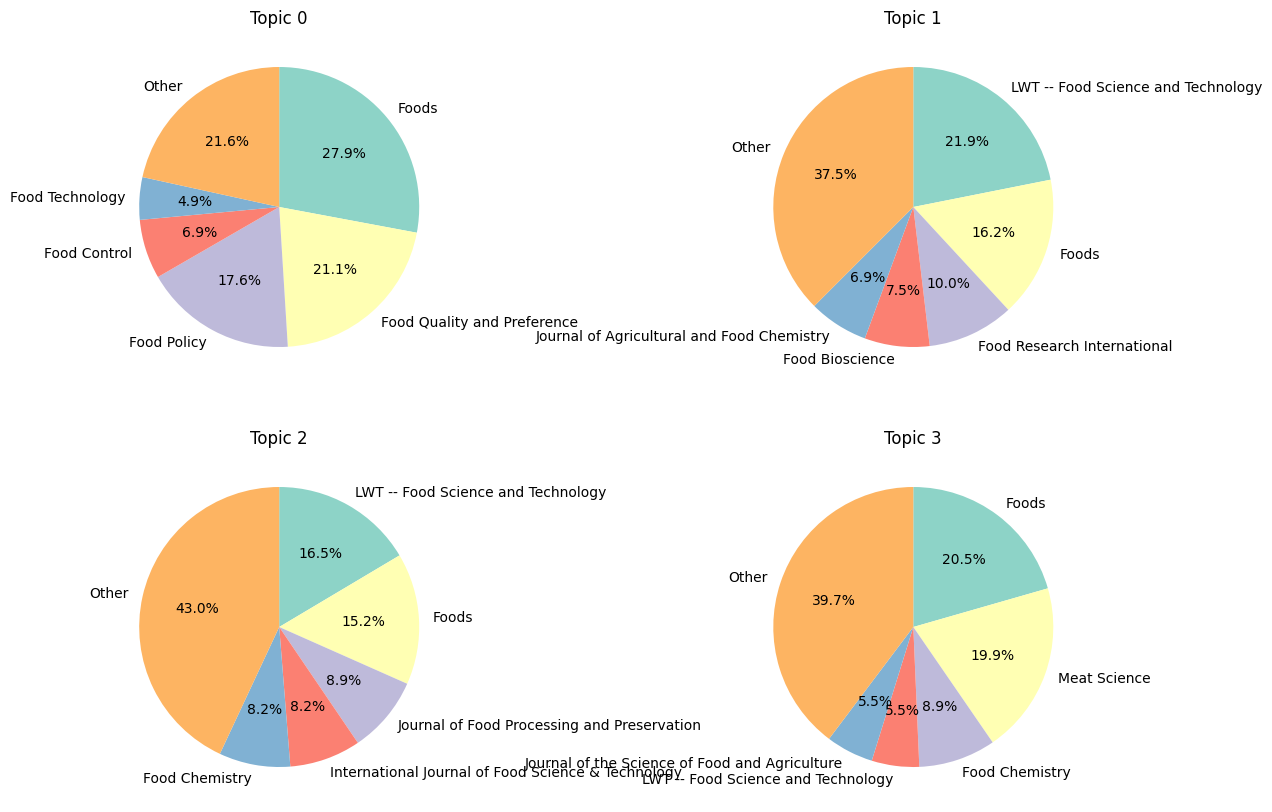

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

grouped_df = df_abs_jour_top.groupby('Topic')['journal'].apply(list).reset_index()

# Show the first 4 topics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    if i < len(grouped_df):
        count_dict = {}
        # Start from topic 0 not -1
        for j in grouped_df["journal"].iloc[i+1]:
            count_dict[j] = grouped_df["journal"].iloc[i+1].count(j)
        count_dict_df = pd.DataFrame(list(count_dict.items()), columns=['Journal', 'Count'])
        count_dict_df = count_dict_df.sort_values(by='Count', ascending=False, ignore_index=True)
        count_dict_df.to_csv(f"count_dict_df{i}.csv")

        # Get the top 5 journals 
        top_journals = count_dict_df.head(5)
        other_count = count_dict_df['Count'].sum() - top_journals['Count'].sum()
        other_count_df = pd.DataFrame({'Journal': ['Other'], 'Count': [other_count]})

        data = pd.concat([top_journals, other_count_df],ignore_index=True)
        
        ax.pie(data["Count"], labels=data["Journal"],startangle=90,counterclock=False,
               autopct='%1.1f%%', colors=sns.color_palette("Set3"))
        ax.set_title(f"Topic {i}")

# Remove empty subplots
for j in range(len(grouped_df), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])


plt.show()
